### Open namepsace and get exetnsions for multichannel volumetric data

In [28]:
import os
from pynwb import load_namespaces, get_class
from pynwb.file import MultiContainerInterface, NWBContainer
import skimage.io as skio
from collections.abc import Iterable
import numpy as np
from pynwb import register_class
from hdmf.utils import docval, get_docval, popargs
from pynwb.ophys import ImageSeries 
from pynwb.core import NWBDataInterface
from hdmf.common import DynamicTable
from hdmf.utils import docval, popargs, get_docval, get_data_shape, popargs_to_dict
from pynwb.file import Device
import pandas as pd
import numpy as np
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from pynwb.epoch import TimeIntervals
from pynwb.file import Subject
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
from pynwb.ophys import OnePhotonSeries, OpticalChannel, ImageSegmentation, Fluorescence, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from datetime import datetime
from datetime import timedelta
from dateutil import tz
import pandas as pd
import scipy.io as sio
from datetime import datetime, timedelta
import tifffile
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume

In [29]:
datapath = os.path.join('/Users', 'danielysprague', 'foco_lab', 'data')

### Creating NWB file for NeuroPAL data

In [30]:
def gen_file(description, identifier, start_date_time, lab, institution, pubs):

    nwbfile = NWBFile(
        session_description = description,
        identifier = identifier,
        session_start_time = start_date_time,
        lab = lab,
        institution = institution,
        related_publications = pubs
    )

    return nwbfile

In [31]:
def create_im_vol(device, channels, location="head", grid_spacing=[0.3208, 0.3208, 0.75], grid_spacing_unit ="micrometers", origin_coords=[0,0,0], origin_coords_unit="micrometers", reference_frame="Worm head"):
    
    # channels should be ordered list of tuples (name, description)

    OptChannels = []
    OptChanRefData = []
    for name, des, wave in channels:
        excite = float(wave.split('-')[0])
        emiss_mid = float(wave.split('-')[1])
        emiss_range = float(wave.split('-')[2][:-1])
        OptChan = OpticalChannelPlus(
            name = name,
            description = des,
            excitation_lambda = excite,
            excitation_range = [excite-1.5, excite+1.5],
            emission_range = [emiss_mid-emiss_range/2, emiss_mid+emiss_range/2],
            emission_lambda = emiss_mid
        )

        OptChannels.append(OptChan)
        OptChanRefData.append(wave)

    OpticalChannelRefs = OpticalChannelReferences(
        name = 'OpticalChannelRefs',
        channels = OptChanRefData
    )

    imaging_vol = ImagingVolume(
        name= 'ImagingVolume',
        optical_channel_plus = OptChannels,
        Order_optical_channels = OpticalChannelRefs,
        description = 'NeuroPAL image of C elegan brain',
        device = device,
        location = location,
        grid_spacing = grid_spacing,
        grid_spacing_unit = grid_spacing_unit,
        origin_coords = origin_coords,
        origin_coords_unit = origin_coords_unit,
        reference_frame = reference_frame
    )

    return imaging_vol, OpticalChannelRefs, OptChannels

In [32]:
def create_vol_seg(imaging_vol, blobs):

    vs = VolumeSegmentation(
        name = 'VolumeSegmentation',
        description = 'Neuron centers for multichannel volumetric image',
        imaging_volume = imaging_vol
    )

    voxel_mask = []

    for i, row in blobs.iterrows():
        x = row['X']
        y = row['Y']
        z = row['Z']
        ID = row['ID']

        voxel_mask.append([np.uint(x),np.uint(y),np.uint(z),1,str(ID)])

    vs.add_roi(voxel_mask=voxel_mask)

    return vs

In [33]:
def create_image(data, name, description, imaging_volume, opt_chan_refs, resolution=[0.3208, 0.3208, 0.75], RGBW_channels=[0,1,2,3]):

    image = MultiChannelVolume(
        name = name,
        Order_optical_channels = opt_chan_refs,
        resolution = resolution,
        description = description,
        RGBW_channels = RGBW_channels,
        data = data,
        imaging_volume = imaging_volume
    )

    return image

In [45]:
'''
Create NWB file from tif file of raw image, neuroPAL software created mat file and csv files of blob locations
'''

def create_file_FOCO(folder, reference_frame):

    worm = folder.split('/')[-1]

    path = folder

    for file in os.listdir(path):
        if file[-4:] =='.tif':
            imfile = path + '/'+file

        elif file[-4:] == '.mat' and file[-6:]!= 'ID.mat':
            matfile = path + '/'+file

        elif file == 'blobs.csv':
            blobs = path +'/'+file

    data = np.transpose(skio.imread(imfile)) # data in XYZC
    #data = data.astype('uint16')
    mat = sio.loadmat(matfile)

    scale = np.asarray(mat['info']['scale'][0][0]).flatten()
    prefs = np.asarray(mat['prefs']['RGBW'][0][0]).flatten()-1 #subtract 1 to adjust for matlab indexing from 1
    
    dt = worm.split('-')
    session_start = datetime(int(dt[0]),int(dt[1]),int(dt[2]), tzinfo=tz.gettz("US/Pacific"))
    
    nwbfile = gen_file('Worm head', worm, session_start, 'Kato lab', 'UCSF', "")

    nwbfile.subject = CElegansSubject(
    subject_id = worm,
    #age = "T2H30M",
    #growth_stage_time = pd.Timedelta(hours=2, minutes=30).isoformat(),
    date_of_birth = session_start, #currently just using the session start time to bypass the requirement for date of birth
    growth_stage = 'YA',
    growth_stage_time=pd.Timedelta(hours=2, minutes=30).isoformat(),
    cultivation_temp = 20.,
    description = dt[3]+'-'+dt[4],
    species  =  "http://purl.obolibrary.org/obo/NCBITaxon_6239",
    sex = "O", #currently just using O for other until support added for other gender specifications
    strain = "OH16230"
    )

    device = nwbfile.create_device(
    name = "Microscope",
    description = "One-photon microscope Weill",
    manufacturer = "Leica"
    )

    channels = [("mNeptune 2.5", "Chroma ET 700/75", "561-700-75m"), ("Tag RFP-T", "Chroma ET 605/70", "561-605-70m"), ("CyOFP1", "Chroma ET 605/70","488-605-70m"), ("GFP-GCaMP", "Chroma ET 525/50","488-525-50m"), ("mTagBFP2", "Chroma ET 460/50", "405-460-50m"),("mNeptune 2.5-far red", "Chroma ET 700/75", "639-700-75m")]
    
    ImagingVol, OptChannelRefs, OptChannels = create_im_vol(device, channels, location= "head", grid_spacing= scale, reference_frame=reference_frame)

    csv = pd.read_csv(blobs)

    vs = create_vol_seg(ImagingVol, csv)

    image= create_image(data, 'NeuroPALImageRaw', worm, ImagingVol, OptChannelRefs, resolution=scale, RGBW_channels=[0,2,4,1])

    nwbfile.add_acquisition(image)

    neuroPAL_module = nwbfile.create_processing_module(
        name = 'NeuroPAL',
        description = 'neuroPAL image data and metadata',
    )    

    processed_im_module = nwbfile.create_processing_module(
        name = 'ProcessedImage',
        description = 'Pre-processed image. Currently median filtered and histogram matched to original neuroPAL images.'
    )

    proc_imvol, proc_optchanrefs, proc_optchanplus = create_im_vol(device, [channels[i] for i in [0,2,4,1]], location="head", grid_spacing=scale, reference_frame=reference_frame)

    proc_imfile = datapath + '/NP_FOCO_hist_med/'+worm+'/hist_med_image.tif'


    proc_data = np.transpose(skio.imread(proc_imfile), (2,1,0,3))
    #proc_data = proc_data.astype('uint16')

    proc_image = create_image(proc_data, 'Hist_match_med_filt', worm, proc_imvol, proc_optchanrefs, resolution=scale, RGBW_channels=[0,1,2,3])

    neuroPAL_module.add(vs)
    neuroPAL_module.add(ImagingVol)
    neuroPAL_module.add(OptChannelRefs)
    neuroPAL_module.add(OptChannels)

    processed_im_module.add(proc_image)
    processed_im_module.add(proc_optchanrefs)
    processed_im_module.add(proc_optchanplus)
    processed_im_module.add(proc_imvol)

    io = NWBHDF5IO(datapath+'/nwb/'+worm+'.nwb', mode='w')
    io.write(nwbfile)
    io.close()

In [47]:
for folder in os.listdir(datapath+'/NP_FOCO_cropped'):
    if folder == '.DS_Store':
        continue 
    print(folder)
    create_file_FOCO(datapath+'/NP_FOCO_cropped/'+folder, reference_frame='worm head')

2022-04-26-w00-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-04-26-w01-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2021-12-03-w00-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-02-22-w04-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-04-01-w00-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-03-05-w00-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-02-12-w00-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-02-12-w01-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-01-22-w04-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


2022-02-11-w03-NP1


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type uint16 is being converted to data type int16 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


In [132]:
def create_file_yemini(folder, reference_frame):

    worm = folder.split('/')[-1]

    path = datapath+'/'+folder

    matfile = None
    csvfile = None
    gcampfile = None

    for file in os.listdir(path):
        if file == 'head.mat':
            matfile = path + '/'+file

        elif file == 'head.csv':
            csvfile = path +'/'+file

        elif file == 'gcamp.mat':
            gcampfile = path+'/'+file

    if not csvfile:
        return 

    #data = np.transpose(skio.imread(imfile), (1,0,2,3)) #data should be XYZC
    #data = data.astype('uint16')
    mat = sio.loadmat(matfile)
    gcamp = sio.loadmat(gcampfile)

    data = np.transpose(mat['data']*4095, (1,0,2,3))

    gcdata = gcamp['data']

    gcdata = np.transpose(gcdata, (3,1,0,2)) # convert data to TXYZ

    scale = np.asarray(mat['info']['scale'][0][0]).flatten()
    prefs = np.asarray(mat['prefs']['RGBW'][0][0]).flatten()-1 #subtract 1 to adjust for matlab indexing from 1
    
    gcscale = np.asarray(gcamp['worm_data']['info'][0][0][0][0][1]).flatten()

    session_start = datetime(int(worm[0:4]),int(worm[4:6]),int(worm[6:8]), tzinfo=tz.gettz("US/Pacific"))

    nwbfile = gen_file('Worm head', worm, session_start, 'Hobert lab', 'Columbia University', ["NeuroPAL: A Multicolor Atlas for Whole-Brain Neuronal Identification in C. elegans", "Extracting neural signals from semi-immobilized animals with deformable non-negative matrix factorization" ])

    nwbfile.subject = CElegansSubject(
    subject_id = worm,
    #age = "T2H30M",
    #growth_stage_time = pd.Timedelta(hours=2, minutes=30).isoformat(),
    date_of_birth = session_start-timedelta(days=2), #currently just using the session start time to bypass the requirement for date of birth
    growth_stage = 'YA',
    #growth_stage_time=pd.Timedelta(hours=2, minutes=30).isoformat(),
    cultivation_temp = 20.,
    description = worm,
    species  =  "http://purl.obolibrary.org/obo/NCBITaxon_6239",
    sex = "O", #currently just using O for other until support added for other gender specifications
    strain = "OH16230"
    )

    device =nwbfile.create_device(
        name = "Spinning disk confocal",
        description = "Spinning Disk Confocal Nikon	Ti-e 60x Objective, 1.2 NA	Nikon CFI Plan Apochromat VC 60XC WI",
        manufacturer = "Nikon"
    )

    if prefs[3]== 4:
        channels = [("mTagBFP2", "Semrock FF01-445/45-25 Brightline", "405-445-45m"), ("CyOFP1", "Semrock FF02-617/73-25 Brightline", "488-610-40m"), ("mNeptune 2.5", "Semrock FF01-731/137-25 Brightline","561-731-70m"), ("GFP-GCaMP", "Semrock FF02-525/40-25 Brightline", "488-525-25m"), ("Tag RFP-T", "Semrock FF02-617/73-25 Brightline", "561-610-40m")]
    elif prefs[3]==3:
        channels = [("mTagBFP2", "Semrock FF01-445/45-25 Brightline", "405-445-25m"), ("CyOFP1", "Semrock FF02-617/73-25 Brightline","488-610-40m"), ("mNeptune 2.5", "Semrock FF01-731/137-25 Brightline","561-731-70m"), ("Tag RFP-T", "Semrock FF02-617/73-25 Brightline", "561-610-40m"), ("GFP-GCaMP", "Semrock FF02-525/40-25 Brightline", "488-525-25m")]

    ImagingVol, OptChannelRefs, OptChannels = create_im_vol(device, channels, location= "head", grid_spacing= scale, reference_frame=reference_frame)

    csv = pd.read_csv(csvfile, skiprows=6)

    blobs = csv[['Real X (um)', 'Real Y (um)', 'Real Z (um)', 'User ID']]
    blobs = blobs.rename(columns={'Real X (um)':'X', 'Real Y (um)':'Y', 'Real Z (um)':'Z', 'User ID':'ID'})
    blobs['X'] = round(blobs['X'].div(scale[0]))
    blobs['Y'] = round(blobs['Y'].div(scale[1]))
    blobs['Z'] = round(blobs['Z'].div(scale[2]))
    blobs = blobs.astype({'X':'int16', 'Y':'int16', 'Z':'int16'})

    vs = create_vol_seg(ImagingVol, blobs)

    image= create_image(data, 'NeuroPALImageRaw', worm, ImagingVol, OptChannelRefs, resolution=scale, RGBW_channels=prefs)

    nwbfile.add_acquisition(image)

    gc_optchan = ("GFP-GCaMP", "Semrock FF02-525/40-25 Brightline","488-525-25m")

    excite = float(gc_optchan[2].split('-')[0])
    emiss_mid = float(gc_optchan[2].split('-')[1])
    emiss_range = float(gc_optchan[2].split('-')[2][:-1])
    
    gcchan = OpticalChannel(
        name = gc_optchan[0],
        description = "Semrock FF02-525/40-25 Brightline",
        emission_lambda = emiss_mid
    )

    gcplane = nwbfile.create_imaging_plane(
        name = 'GCamp_implane',
        description = 'Imaging plane for GCamp data acquisition',
        excitation_lambda = float(gc_optchan[2].split('-')[0]),
        optical_channel = gcchan,
        location = 'head',
        indicator = 'GFP',
        device = device,
        grid_spacing = gcscale,
        grid_spacing_unit = 'um'
    )

    gcamp = OnePhotonSeries(
        name = 'GCaMP_series',
        description = 'Time Series GCaMP activity data',
        data = gcdata,
        unit = 'grey count values from 0-255',
        resolution = 1.0,
        rate = 4.0,
        imaging_plane = gcplane,
    )


    nwbfile.add_acquisition(gcamp)

    neuroPAL_module = nwbfile.create_processing_module(
        name = 'NeuroPAL',
        description = 'neuroPAL image data and metadata',
    )    

    neuroPAL_module.add(vs)
    neuroPAL_module.add(ImagingVol)
    neuroPAL_module.add(OptChannelRefs)
    neuroPAL_module.add(OptChannels)

    #gcamp_module = nwbfile.create_processing_module(
    #    name = 'GCaMP',
    #    description = 'GCaMP time series data and metadata'
    #)
    #gcamp_module.add(gcplane)
    #gcamp_module.add(gcchan)

    io = NWBHDF5IO(datapath+'/Yemini_NWB/'+worm+'.nwb', mode='w')
    io.write(nwbfile)
    io.close()


/Users/danielysprague/foco_lab/data


In [133]:
#folder = '/Yemini_21' + '/OH16230' +'/Heads'+'/20190924_01'
#reference_frame = 'worm_head'

for folder in os.listdir('/Users/danielysprague/foco_lab/data/Yemini_21/OH16230/Heads'):
    print(folder)
    create_file_yemini('/Yemini_21/OH16230/Heads/'+folder, reference_frame='worm head')


20190928_03
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_05
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190924_01
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190929_05
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190929_02
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190925_01
(128, 256, 21, 963)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190929_03
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20191104_10
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_11
(128, 256, 21, 963)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20191030_03
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190924_03
(128, 256, 21, 963)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_07
(128, 256, 21, 960)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190924_02
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_08
(128, 256, 21, 961)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_01
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190929_06
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190925_04
(128, 256, 21, 961)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190929_07
(128, 256, 21, 937)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20191104_08
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20190928_13
(128, 256, 21, 962)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


20191030_07
(128, 256, 21, 961)


/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/RGBW_channels': Value with data type uint8 is being converted to data type int8 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'MultiChannelVolume/data': Value with data type float64 is being converted to data type int64 (min specification: int16).
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/Applications/anaconda3/envs/eats-worm/lib/python3.11/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'ImagingVolume/origin_coords': Value with data type int64 is being converted to data type float64 (min specification: float32).
  warnings.warn(full_warning_msg, DtypeConversionWarning)


: 

In [18]:
print(os.getcwd())

/Users/danielysprague/foco_lab/eats-worm/NWB


In [34]:
df = pd.read_csv(datapath+'/Yemini_21' + '/OH16230' +'/Heads'+'/20190924_01/head.csv', skiprows=6)

df['Real X (um)'] = round(df['Real X (um)'].div(0.5))
df = df.astype({'Real X (um)':'int16'})

df.head()

,User ID,User Confidence,Emphasized?,Auto ID,Auto Confidence,Unnamed: 5,Real X (um),Real Y (um),Real Z (um),Unnamed: 9,Z-Scored Red,Z-Scored Green,Z-Scored Blue,Z-Scored White,Unnamed: 14,Estimated GFP,Max GFP,Normalized GFP,Unnamed: 18
0,IL2VL,1.0,0,IL2VL,1.0,NaN,2,37.800677,18.0,NaN,1.682923,0.535334,-0.442140,2.216146,NaN,0.172753,0.176199,0.077952,NaN
1,IL2DR,1.0,0,IL2DR,1.0,NaN,5,13.618080,7.5,NaN,4.758339,3.003751,0.045785,5.268976,NaN,0.153797,0.170136,0.029189,NaN
2,I2R,1.0,0,I2R,1.0,NaN,18,32.941016,6.0,NaN,7.325581,0.114606,3.556815,7.034241,NaN,0.521796,0.553303,0.074179,NaN
3,I2L,1.0,0,I2L,1.0,NaN,18,30.626893,21.0,NaN,4.012856,0.338398,1.019603,4.012230,NaN,0.206112,0.221357,0.051371,NaN
4,MCL,1.0,0,MCL,1.0,NaN,20,29.354125,18.0,NaN,0.335780,-0.030858,-0.051800,2.964372,NaN,0.085460,0.093213,0.028829,NaN


### Read NWB files and recreate relevant files

In [13]:
with NWBHDF5IO(datapath+"/nwb/2021-12-03-w00-NP1.nwb", mode='r', load_namespaces=True) as io:
    read_nwbfile = io.read()
    print(read_nwbfile.processing['NeuroPAL'])
    subject = read_nwbfile.subject #get the metadata about the experiment subject
    growth_stage = subject.growth_stage
    image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:] #get the neuroPAL image as a np array
    resolution = read_nwbfile.acquisition['NeuroPALImageRaw'].resolution[:] #get the resolution of the image in um/pixels
    channels = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    seg = read_nwbfile.processing['NeuroPAL']['VolumeSegmentation'].voxel_mask[:] #get the locations of neuron centers
    im_vol = read_nwbfile.processing['NeuroPAL']['ImagingVolume'] #get the metadata associated with the imaging acquisition
    optchans = read_nwbfile.processing['NeuroPAL']['ImagingVolume'].optical_channel_plus[:] #get information about all of the optical channels used in acquisition
    chan_refs = read_nwbfile.processing['NeuroPAL']['OpticalChannelRefs'].channels[:] #get the order of the optical channels in the image
    proc_image = read_nwbfile.processing['ProcessedImage']['Hist_match_med_filt'].data[:] #get the pre-processed image



NeuroPAL pynwb.base.ProcessingModule at 0x5724283600
Fields:
  data_interfaces: {
    ImagingVolume <class 'ndx_multichannel_volume.ndx_multichannel_volume.ImagingVolume'>,
    OpticalChannelRefs <class 'abc.OpticalChannelReferences'>,
    VolumeSegmentation <class 'ndx_multichannel_volume.ndx_multichannel_volume.VolumeSegmentation'>
  }
  description: neuroPAL image data and metadata



In [107]:
print(image.shape)

(1000, 240, 41, 6)


In [71]:
with NWBHDF5IO(datapath+"/Yemini_nwb/20190924_01.nwb", mode='r', load_namespaces=True) as io:
    read_nwbfile = io.read()
    subject = read_nwbfile.subject #get the metadata about the experiment subject
    growth_stage = subject.growth_stage
    image = read_nwbfile.acquisition['NeuroPALImageRaw'].data[:] #get the neuroPAL image as a np array
    gcdata = read_nwbfile.acquisition['GCaMP_series'].data[:]
    gcplane = read_nwbfile.acquisition['GCaMP_series'].imaging_plane
    resolution = read_nwbfile.acquisition['NeuroPALImageRaw'].resolution[:] #get the resolution of the image in um/pixels
    channels = read_nwbfile.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
    seg = read_nwbfile.processing['NeuroPAL']['VolumeSegmentation'].voxel_mask[:] #get the locations of neuron centers
    im_vol = read_nwbfile.processing['NeuroPAL']['ImagingVolume'] #get the metadata associated with the imaging acquisition
    optchans = read_nwbfile.processing['NeuroPAL']['ImagingVolume'].optical_channel_plus[:] #get information about all of the optical channels used in acquisition
    chan_refs = read_nwbfile.processing['NeuroPAL']['OpticalChannelRefs'].channels[:] #get the order of the optical channels in the image



In [66]:
print(image.shape)

(256, 512, 21, 5)


In [67]:
print(channels)

[2 1 0 4]


In [91]:
'''
Recreate blobs.csv from vol_seg
'''

blobs = pd.DataFrame.from_records(seg, columns=['X', 'Y','Z','weight', 'ID'])
blobs = blobs.drop(['weight'], axis=1)
blobs = blobs.replace('nan', np.nan, regex=True)
#blobs = blobs.replace('nan', '', regex=True)
#blobs.to_csv(datapath+'/nwb/test.csv')


In [92]:
print(blobs)

       x    y   z   ID
0    154   67  19  NaN
1    164   91  23  NaN
2    167   95  33  NaN
3    191  104  32  NaN
4    201  115  34  I2L
..   ...  ...  ..  ...
167  450  179  10  NaN
168  462  183  10  NaN
169  477  185  10  NaN
170  528  200  13  NaN
171  545  203  13  NaN

[172 rows x 4 columns]


In [128]:
import matplotlib.pyplot as plt

newimage = image
RGB = newimage[:,:,:,channels[:-1]]

print(newimage.shape)

Zmax = np.max(RGB, axis=2)
Ymax = np.max(RGB, axis=1)



(1000, 240, 41, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


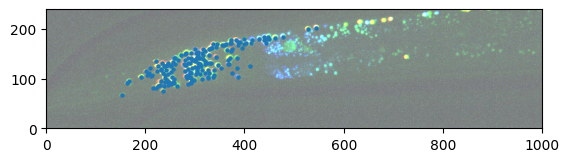

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


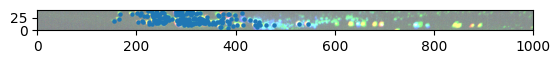

In [129]:
plt.figure()

plt.imshow(np.transpose(Zmax, [1,0,2]))
plt.scatter(blobs['x'], blobs['y'], s=5)
plt.xlim((0, Zmax.shape[0]))
plt.ylim((0, Zmax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

plt.figure()

plt.imshow(np.transpose(Ymax, [1,0,2]))
plt.scatter(blobs['x'], blobs['z'], s=5)
plt.xlim((0, Ymax.shape[0]))
plt.ylim((0, Ymax.shape[1]))
plt.gca().set_aspect('equal')

plt.show()

In [15]:
'''
Recreate original image from acquisition raw image
'''
print(image.shape)

#im = np.transpose(image,(2,3,1,0)) #have to flip some of the axes to align with how FIJI reads tiff images
#image = image.astype('uint16')
#print(im.dtype)
#print(im.shape)

tifffile.imwrite(datapath + '/nwb/test.tif', image, imagej = True)

(45, 6, 240, 1000)


In [16]:
'''
Recreate histogram matched image from processed data
'''

print(proc_image.shape)

#im = np.transpose(proc_image, (3,0,2,1)) #have to flip some of the axes to align with how FIJI reads tiff images
#proc_image = proc_image.astype('uint16')
print(proc_image.dtype)

tifffile.imwrite(datapath + '/nwb/test_proc.tif', proc_image, imagej = True)

(45, 4, 240, 1000)
uint16


: 